In [1]:
# Install necessary packages
!pip install datasets scikit-learn sentence-transformers matplotlib umap-learn pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time

# Data processing and ML libraries
from datasets import load_dataset
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import umap

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Text cleaning function
def clean_text_list(text_list):
    # Handle None values and convert all to strings
    cleaned_list = [str(text) if text is not None else "" for text in text_list]

    # Helper function to remove wallet addresses
    def remove_wallets(text):
        wallet_pattern = r'0x[a-fA-F0-9]{40}|[13][a-km-zA-HJ-NP-Z1-9]{25,34}'
        return re.sub(wallet_pattern, '', text)

    # Apply cleaning operations
    def clean_text(text):
        # Remove Asian characters
        text = re.sub(r'[\u4e00-\u9fff]+', '', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        # Remove RT prefix
        text = re.sub(r'RT : ', '', text)
        # Replace & with 'and'
        text = re.sub(r'&', 'and', text)
        # Handle special characters and quotes
        text = re.sub(r'â€™', '\'', text)
        text = re.sub(r'["&;]', '', text)
        text = re.sub(r'', '', text)  # Zero-width space
        # Remove .X or .x
        text = re.sub(r'\.[Xx]', '', text)
        # Normalize multiple dots to ellipsis
        text = re.sub(r'\.\.+', '...', text)
        # Remove standalone @ and pipe symbols
        text = re.sub(r'@|\|', '', text)
        # Normalize spaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Convert to lowercase
        text = text.lower()
        # Remove wallet addresses
        text = remove_wallets(text)
        return text

    # Apply cleaning to all texts
    cleaned_list = [clean_text(text) for text in cleaned_list]
    return cleaned_list

# Function to map sentiment labels (for later evaluation)
def sentiment_map(text):
    if 'Bullish' in text:
        return 0
    elif 'Neutral' in text:
        return 1
    else:
        return 2  # Bearish

In [4]:
# Load dataset
print("Loading dataset...")
start_time = time.time()

data = load_dataset("StephanAkkerman/financial-tweets-crypto")
train_dataset = data['train']
train_dataset = train_dataset.filter(lambda data: data['sentiment'] is not None)

# Clean texts
texts = clean_text_list(train_dataset['description'])
# Get true labels for later comparison
true_labels = [sentiment_map(sent) for sent in train_dataset['sentiment']]

print(f"Total samples: {len(texts)}")
print(f"Dataset loaded and processed in {time.time() - start_time:.2f} seconds")

# Check sentiment distribution
sentiment_counts = Counter(true_labels)
print("\nSentiment distribution in original dataset:")
for sentiment, count in sorted(sentiment_counts.items()):
    sentiment_name = ["Bullish", "Neutral", "Bearish"][sentiment]
    print(f"{sentiment_name}: {count} samples ({count/len(true_labels)*100:.2f}%)")

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

crypto.csv:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57935 [00:00<?, ? examples/s]

Filter:   0%|          | 0/57935 [00:00<?, ? examples/s]

Total samples: 48692
Dataset loaded and processed in 21.44 seconds

Sentiment distribution in original dataset:
Bullish: 29276 samples (60.12%)
Neutral: 10329 samples (21.21%)
Bearish: 9087 samples (18.66%)


In [5]:
# Extract features using Sentence Transformers
def extract_features(texts, model_name='all-MiniLM-L6-v2'):
    print(f"Extracting features using {model_name}...")
    start_time = time.time()

    model = SentenceTransformer(model_name)

    # Process in batches to avoid memory issues
    batch_size = 256  # Larger batch size for speed
    embeddings = []

    total_batches = (len(texts) + batch_size - 1) // batch_size
    for i in range(0, len(texts), batch_size):
        if i % (10 * batch_size) == 0:
            print(f"Processing batch {i//batch_size + 1}/{total_batches}...")

        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        embeddings.append(batch_embeddings)

    # Combine all batches
    embeddings = np.vstack(embeddings)

    print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")
    print(f"Embedding shape: {embeddings.shape}")

    return embeddings

# Get embeddings
embeddings = extract_features(texts)

# Normalize embeddings
norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
print("Embeddings normalized")

Extracting features using all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing batch 1/191...
Processing batch 11/191...
Processing batch 21/191...
Processing batch 31/191...
Processing batch 41/191...
Processing batch 51/191...
Processing batch 61/191...
Processing batch 71/191...
Processing batch 81/191...
Processing batch 91/191...
Processing batch 101/191...
Processing batch 111/191...
Processing batch 121/191...
Processing batch 131/191...
Processing batch 141/191...
Processing batch 151/191...
Processing batch 161/191...
Processing batch 171/191...
Processing batch 181/191...
Processing batch 191/191...
Feature extraction completed in 1317.79 seconds
Embedding shape: (48692, 384)
Embeddings normalized


In [6]:
# Reduce dimensionality with UMAP for better clustering
def reduce_dimensions(embeddings, n_components=50, random_state=42):
    print(f"Reducing dimensions to {n_components} components...")
    start_time = time.time()

    # Use UMAP for dimensionality reduction
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=15,
        min_dist=0.1
    )
    reduced_embeddings = reducer.fit_transform(embeddings)

    print(f"Dimensionality reduction completed in {time.time() - start_time:.2f} seconds")
    print(f"Reduced embedding shape: {reduced_embeddings.shape}")

    return reduced_embeddings

# Apply dimensionality reduction
reduced_embeddings = reduce_dimensions(embeddings)

Reducing dimensions to 50 components...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensionality reduction completed in 207.28 seconds
Reduced embedding shape: (48692, 50)


In [7]:
# Implement BIRCH Clustering
def run_birch_clustering(embeddings, n_clusters=3, threshold=0.5, branching_factor=50):
    print(f"Running BIRCH Clustering with {n_clusters} clusters...")
    print(f"Parameters: threshold={threshold}, branching_factor={branching_factor}")
    start_time = time.time()

    # Initialize and fit the model
    birch = Birch(
        n_clusters=n_clusters,
        threshold=threshold,
        branching_factor=branching_factor
    )
    cluster_labels = birch.fit_predict(embeddings)

    # Get cluster centers (subcluster centers as approximation)
    cluster_centers = birch.subcluster_centers_

    # Count samples in each cluster
    counter = Counter(cluster_labels)
    print("\nCluster distribution:")
    for cluster, count in sorted(counter.items()):
        print(f"Cluster {cluster}: {count} samples ({count/len(embeddings)*100:.2f}%)")

    # Calculate silhouette score
    silhouette = silhouette_score(embeddings, cluster_labels)
    print(f"Silhouette score: {silhouette:.4f}")

    print(f"Clustering completed in {time.time() - start_time:.2f} seconds")

    return cluster_labels, cluster_centers, birch

# Run BIRCH clustering
cluster_labels, cluster_centers, birch_model = run_birch_clustering(reduced_embeddings)

Running BIRCH Clustering with 3 clusters...
Parameters: threshold=0.5, branching_factor=50

Cluster distribution:
Cluster 0: 20059 samples (41.20%)
Cluster 1: 24277 samples (49.86%)
Cluster 2: 4356 samples (8.95%)
Silhouette score: 0.2487
Clustering completed in 52.57 seconds


In [10]:
# Try different BIRCH parameters (optional)
def tune_birch_parameters(embeddings):
    print("Tuning BIRCH parameters...")

    # Parameters to try
    thresholds = [0.3, 0.5, 0.7, 1.0]
    branching_factors = [50, 100, 200]

    # Store results
    results = []

    for threshold in thresholds:
        for branching_factor in branching_factors:
            print(f"\nTrying threshold={threshold}, branching_factor={branching_factor}")

            # Run BIRCH
            birch = Birch(
                n_clusters=3,  # Fixed number of clusters for sentiment analysis
                threshold=threshold,
                branching_factor=branching_factor
            )
            labels = birch.fit_predict(embeddings)

            # Calculate metrics
            try:
                silhouette = silhouette_score(embeddings, labels)
                ari = adjusted_rand_score(true_labels, labels)
                nmi = normalized_mutual_info_score(true_labels, labels)

                # Count distribution
                cluster_counts = Counter(labels)

                # Save results
                results.append({
                    'threshold': threshold,
                    'branching_factor': branching_factor,
                    'silhouette': silhouette,
                    'ari': ari,
                    'nmi': nmi,
                    'cluster_counts': dict(cluster_counts)
                })

                print(f"Silhouette: {silhouette:.4f}, ARI: {ari:.4f}, NMI: {nmi:.4f}")

            except Exception as e:
                print(f"Error calculating metrics: {e}")
                continue

    # Convert to DataFrame for easy viewing
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('silhouette', ascending=False)
        print("\nTop 5 parameter combinations by silhouette score:")
        print(results_df[['threshold', 'branching_factor', 'silhouette', 'ari', 'nmi']].head(5))

        # Get best parameters
        best_row = results_df.iloc[0]
        best_threshold = best_row['threshold']
        best_branching_factor = best_row['branching_factor']

        print(f"\nBest parameters: threshold={best_threshold}, branching_factor={best_branching_factor}")
        return best_threshold, best_branching_factor
    else:
        print("No valid results found")
        return 0.5, 50  # Default values

# Uncomment to run parameter tuning (this will take time)
best_threshold, best_branching_factor = tune_birch_parameters(reduced_embeddings)
cluster_labels, cluster_centers, birch_model = run_birch_clustering(
    reduced_embeddings, threshold=best_threshold, branching_factor=best_branching_factor
)

Tuning BIRCH parameters...

Trying threshold=0.3, branching_factor=50
Silhouette: 0.2408, ARI: 0.0037, NMI: 0.0025

Trying threshold=0.3, branching_factor=100
Silhouette: 0.2325, ARI: 0.0006, NMI: 0.0022

Trying threshold=0.3, branching_factor=200
Silhouette: 0.2458, ARI: 0.0028, NMI: 0.0020

Trying threshold=0.5, branching_factor=50
Silhouette: 0.2487, ARI: -0.0027, NMI: 0.0033

Trying threshold=0.5, branching_factor=100
Silhouette: 0.2440, ARI: 0.0022, NMI: 0.0022

Trying threshold=0.5, branching_factor=200
Silhouette: 0.2353, ARI: -0.0001, NMI: 0.0023

Trying threshold=0.7, branching_factor=50
Silhouette: 0.3413, ARI: 0.0004, NMI: 0.0029

Trying threshold=0.7, branching_factor=100
Silhouette: 0.3350, ARI: -0.0009, NMI: 0.0022

Trying threshold=0.7, branching_factor=200
Silhouette: 0.3103, ARI: 0.0012, NMI: 0.0015

Trying threshold=1.0, branching_factor=50
Silhouette: 0.3155, ARI: -0.0001, NMI: 0.0034

Trying threshold=1.0, branching_factor=100
Silhouette: 0.3442, ARI: -0.0003, NMI: 

Visualizing clusters and ground truth side-by-side...
Visualization completed in 0.74 seconds


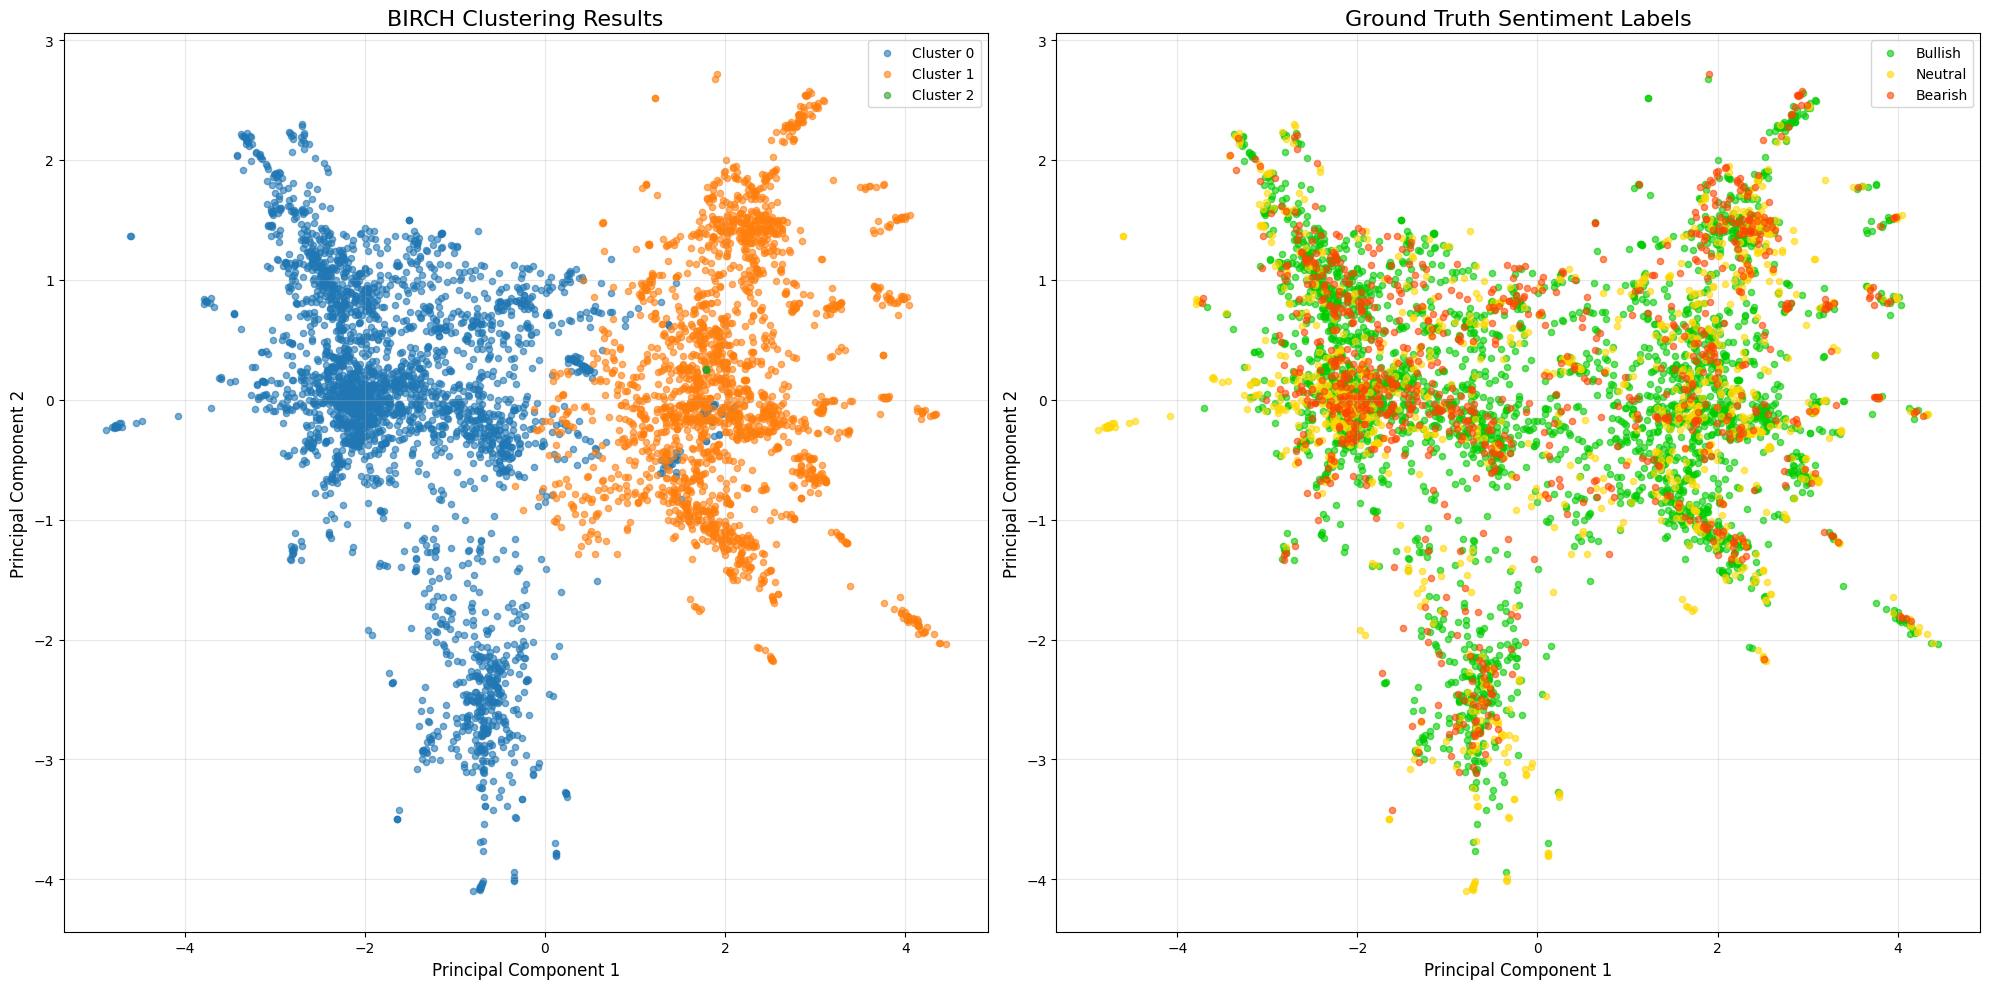

In [11]:
# Visualize clusters and ground truth side-by-side using PCA for 2D representation
def visualize_clusters_with_ground_truth(embeddings, cluster_labels, true_labels, centers=None, max_points=5000):
    print("Visualizing clusters and ground truth side-by-side...")
    start_time = time.time()

    # Sample data if too large
    if len(embeddings) > max_points:
        indices = np.random.choice(len(embeddings), max_points, replace=False)
        sample_embeddings = embeddings[indices]
        sample_cluster_labels = cluster_labels[indices]
        sample_true_labels = true_labels[indices] if isinstance(true_labels, np.ndarray) else np.array(true_labels)[indices]
    else:
        sample_embeddings = embeddings
        sample_cluster_labels = cluster_labels
        sample_true_labels = true_labels if isinstance(true_labels, np.ndarray) else np.array(true_labels)

    # Reduce to 2D for visualization using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(sample_embeddings)

    # Plot centers if provided
    if centers is not None:
        centers_2d = pca.transform(centers)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Define nice colors for the clusters
    cluster_colors = ['#2077B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

    # Define colors for sentiment labels (Bullish, Neutral, Bearish)
    sentiment_colors = ['#00CC00', '#FFD700', '#FF4500']  # Green, Gold, Red-Orange
    sentiment_names = ["Bullish", "Neutral", "Bearish"]

    # Plot 1: Predicted Clusters
    for label in sorted(set(sample_cluster_labels)):
        mask = sample_cluster_labels == label
        ax1.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=20,
            c=cluster_colors[label % len(cluster_colors)],
            alpha=0.6,
            label=f'Cluster {label}'
        )

    # Plot cluster centers if provided
    if centers is not None and len(centers) <= 10:  # Only if few centers
        ax1.scatter(
            centers_2d[:, 0],
            centers_2d[:, 1],
            s=150,
            c='black',
            alpha=1.0,
            marker='X',
            label='Cluster centers'
        )

    ax1.set_title('BIRCH Clustering Results', fontsize=16)
    ax1.set_xlabel('Principal Component 1', fontsize=12)
    ax1.set_ylabel('Principal Component 2', fontsize=12)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Ground Truth Sentiment Labels
    for label in sorted(set(sample_true_labels)):
        mask = sample_true_labels == label
        ax2.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=20,
            c=sentiment_colors[label % len(sentiment_colors)],
            alpha=0.6,
            label=sentiment_names[label]
        )

    ax2.set_title('Ground Truth Sentiment Labels', fontsize=16)
    ax2.set_xlabel('Principal Component 1', fontsize=12)
    ax2.set_ylabel('Principal Component 2', fontsize=12)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Adjust layout
    plt.tight_layout()
    print(f"Visualization completed in {time.time() - start_time:.2f} seconds")
    plt.show()

# Visualize the clusters alongside ground truth
visualize_clusters_with_ground_truth(reduced_embeddings, cluster_labels, true_labels)

Analyzing clusters in relation to true sentiment labels...

Cluster 0 analysis (27373 samples):
Bullish: 16257 samples (59.39%)
Neutral: 5472 samples (19.99%)
Bearish: 5644 samples (20.62%)
Dominant sentiment: Bullish (59.39%)

Cluster 1 analysis (21250 samples):
Bullish: 12984 samples (61.10%)
Neutral: 4823 samples (22.70%)
Bearish: 3443 samples (16.20%)
Dominant sentiment: Bullish (61.10%)

Cluster 2 analysis (69 samples):
Bullish: 35 samples (50.72%)
Neutral: 34 samples (49.28%)
Dominant sentiment: Bullish (50.72%)

Adjusted Rand Index: -0.0003
Normalized Mutual Information: 0.0027


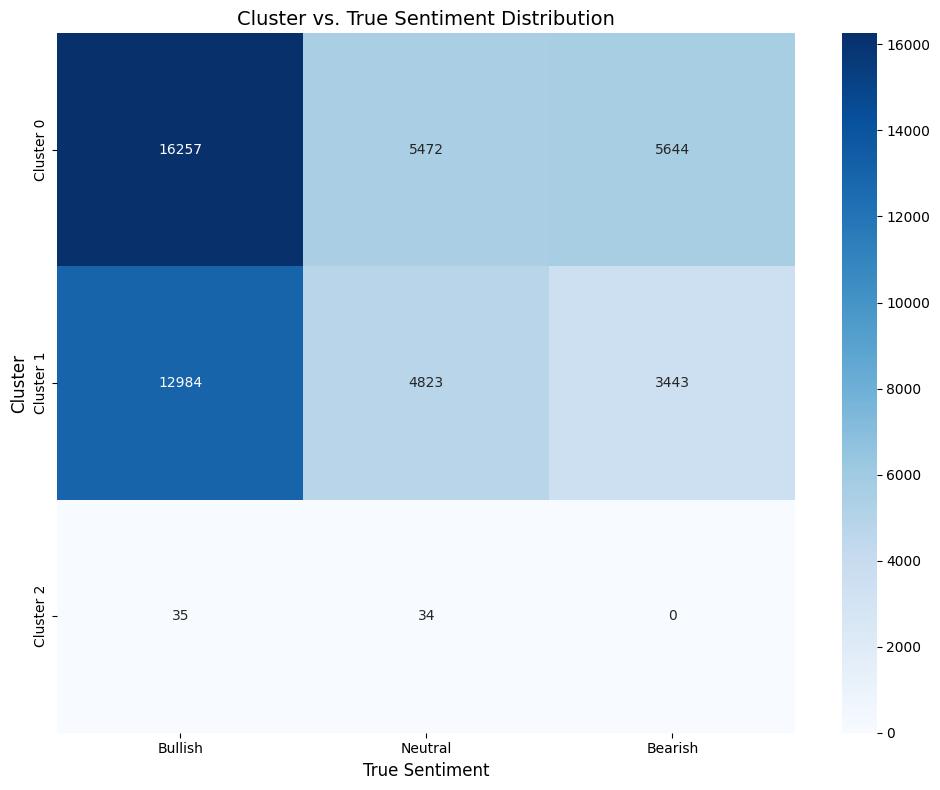


Proposed cluster-to-sentiment mapping:
Cluster 0 → Bullish
Cluster 1 → Bullish
Cluster 2 → Bullish


In [12]:
# Analyze clusters in relation to true sentiment labels
def analyze_clusters(cluster_labels, true_labels):
    print("Analyzing clusters in relation to true sentiment labels...")

    # Convert true_labels to numpy array for easier manipulation
    true_labels = np.array(true_labels)

    # Define sentiment names for readability
    sentiment_names = {0: "Bullish", 1: "Neutral", 2: "Bearish"}

    # Analyze each cluster
    clusters = sorted(set(cluster_labels))

    # Create a confusion matrix-like structure
    conf_matrix = np.zeros((len(clusters), len(sentiment_names)), dtype=int)

    for cluster in clusters:
        # Get indices of tweets in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get the true sentiments for these tweets
        cluster_true_sentiments = true_labels[cluster_indices]

        # Count sentiment distribution
        sentiment_counts = Counter(cluster_true_sentiments)
        total = len(cluster_indices)

        print(f"\nCluster {cluster} analysis ({total} samples):")
        for sentiment, count in sorted(sentiment_counts.items()):
            conf_matrix[cluster, sentiment] = count
            print(f"{sentiment_names[sentiment]}: {count} samples ({count/total*100:.2f}%)")

        # Find the dominant sentiment
        dominant_sentiment = max(sentiment_counts.items(), key=lambda x: x[1])[0]
        dominant_percent = sentiment_counts[dominant_sentiment] / total * 100

        print(f"Dominant sentiment: {sentiment_names[dominant_sentiment]} ({dominant_percent:.2f}%)")

    # Calculate metrics
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"\nAdjusted Rand Index: {ari:.4f}")
    print(f"Normalized Mutual Information: {nmi:.4f}")

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[sentiment_names[i] for i in range(len(sentiment_names))],
        yticklabels=[f'Cluster {i}' for i in clusters]
    )
    plt.xlabel('True Sentiment', fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.title('Cluster vs. True Sentiment Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Attempt to map clusters to sentiments
    cluster_to_sentiment = {}
    for cluster in clusters:
        dominant_sentiment = np.argmax(conf_matrix[cluster])
        cluster_to_sentiment[cluster] = dominant_sentiment

    print("\nProposed cluster-to-sentiment mapping:")
    for cluster, sentiment in cluster_to_sentiment.items():
        print(f"Cluster {cluster} → {sentiment_names[sentiment]}")

    return cluster_to_sentiment

# Analyze clusters
cluster_to_sentiment = analyze_clusters(cluster_labels, true_labels)